In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('cut_market_info.csv')
data

,date,store_nbr,item_nbr,unit_sales,onpromotion,month,dcoilwtico,city,state,type,cluster,family,class,perishable,holiday_type,locale,locale_name,description,transferred
0,2016-10-26,6,1489881,6.000,1.0,2016-10,48.75,Quito,Pichincha,D,13,PRODUCE,2018,1,WorkingDay,WorkingDay,WorkingDay,WorkingDay,WorkingDay
1,2014-06-02,9,953609,7.000,0.0,2014-06,103.07,Quito,Pichincha,B,6,CLEANING,3046,0,WorkingDay,WorkingDay,WorkingDay,WorkingDay,WorkingDay
2,2017-06-18,21,1946155,5.000,0.0,2017-06,44.73,Santo Domingo,Santo Domingo de los Tsachilas,B,6,DELI,2650,1,WorkingDay,WorkingDay,WorkingDay,WorkingDay,WorkingDay
3,2016-07-09,46,119023,6.000,0.0,2016-07,45.37,Quito,Pichincha,A,14,CLEANING,3026,0,WorkingDay,WorkingDay,WorkingDay,WorkingDay,WorkingDay
4,2016-08-04,43,760319,7.707,0.0,2016-08,41.92,Esmeraldas,Esmeraldas,E,10,POULTRY,2416,1,WorkingDay,WorkingDay,WorkingDay,WorkingDay,WorkingDay
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191917,2015-08-25,17,220432,10.000,0.0,2015-08,39.15,Quito,Pichincha,C,12,GROCERY I,1080,0,WorkingDay,WorkingDay,WorkingDay,WorkingDay,WorkingDay
191918,2014-07-03,30,890375,5.000,0.0,2014-07,104.76,Guayaquil,Guayas,C,3,GROCERY I,1002,0,Holiday,Local,El Carmen,Cantonizacion de El Carmen,Holiday
191919,2014-08-13,44,795610,38.000,0.0,2014-08,97.57,Quito,Pichincha,A,5,FROZEN FOODS,2220,0,WorkingDay,WorkingDay,WorkingDay,WorkingDay,WorkingDay
191920,2013-10-01,34,213788,3.000,NaN,2013-10,102.09,Guayaquil,Guayas,B,6,GROCERY I,1096,0,WorkingDay,WorkingDay,WorkingDay,WorkingDay,WorkingDay


In [3]:
X = data.drop('unit_sales', axis = 1)
y = data['unit_sales']

#msle
y = y.apply(np.log1p)

X_train, X_test = X[X['date']<'2017-06-01'], X[X['date']>='2017-06-01']
y_train, y_test = y[y.index.isin(X_train.index)], y[y.index.isin(X_test.index)]

# уберем дату

X = X.drop('date', axis = 1)
X_train = X_train.drop('date', axis = 1)
X_test = X_test.drop('date', axis = 1)

object_cols = ['store_nbr', 'item_nbr', 'onpromotion', 'month',
               'city', 'state', 'type', 'cluster', 'family',
               'class', 'perishable', 'holiday_type', 'locale',
               'locale_name', 'description', 'transferred']

X[object_cols] = X[object_cols].astype(object)
X_train[object_cols] = X_train[object_cols].astype(object)
X_test[object_cols] = X_test[object_cols].astype(object)

In [4]:
from sklearn.model_selection import TimeSeriesSplit
splitter = TimeSeriesSplit(n_splits = 3)

In [5]:
!pip install category-encoders

In [6]:
# Запишем колонки для трансформации
cols_for_ohe = [x for x in X_train.columns if X_train[x].nunique()<5]
cols_for_mte = [x for x in X_train.columns if X_train[x].nunique()>=5]
numeric_cols = list(X_train.select_dtypes(exclude='object').columns)


# Запишем индексы этих колонок
cols_for_ohe_idx = [list(X_train.columns).index(col) for col in cols_for_ohe]
cols_for_mte_idx = [list(X_train.columns).index(col) for col in cols_for_mte]
numeric_cols_idx = [list(X_train.columns).index(col) for col in numeric_cols]

In [7]:
from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder
from category_encoders.one_hot import OneHotEncoder
from sklearn.preprocessing import StandardScaler

# Трансформации
t = [('OneHotEncoder',  OneHotEncoder(), cols_for_ohe_idx),
    ('MeanTargetEncoder',  TargetEncoder(), cols_for_mte_idx),
    ('StandardScaler',  StandardScaler(), numeric_cols_idx)]

col_transform = ColumnTransformer(transformers = t)

In [8]:
col_transform.fit(X_train, y_train)

ColumnTransformer(transformers=[('OneHotEncoder', OneHotEncoder(), [2, 11, 13]),
                                ('MeanTargetEncoder', TargetEncoder(),
                                 [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 15,
                                  16]),
                                ('StandardScaler', StandardScaler(), [4])])

In [9]:
col_transform.transform(X_train)

array([[ 1.        ,  0.        ,  0.        , ...,  1.74964584,
         1.74964584, -0.56429425],
       [ 0.        ,  1.        ,  0.        , ...,  1.74964584,
         1.74964584,  1.67987008],
       [ 0.        ,  1.        ,  0.        , ...,  1.74964584,
         1.74964584, -0.70393481],
       ...,
       [ 0.        ,  1.        ,  0.        , ...,  1.74964584,
         1.74964584,  1.45264431],
       [ 0.        ,  0.        ,  1.        , ...,  1.74964584,
         1.74964584,  1.63938258],
       [ 0.        ,  1.        ,  0.        , ...,  1.74964584,
         1.74964584, -0.63204884]])

In [10]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline

pipe = Pipeline([('custom_transformer', col_transform),
                ('decision_tree', DecisionTreeRegressor())])
pipe.fit(X_train, y_train)

Pipeline(steps=[('custom_transformer',
                 ColumnTransformer(transformers=[('OneHotEncoder',
                                                  OneHotEncoder(),
                                                  [2, 11, 13]),
                                                 ('MeanTargetEncoder',
                                                  TargetEncoder(),
                                                  [0, 1, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 12, 14, 15, 16]),
                                                 ('StandardScaler',
                                                  StandardScaler(), [4])])),
                ('decision_tree', DecisionTreeRegressor())])

In [11]:
train_preds = pipe.predict(X_train)
test_preds = pipe.predict(X_test)

print(f'Качество на трейне: {round(np.mean((y_train - train_preds)**2),3)}')
print(f'Качество на тесте: {round(np.mean((y_test - test_preds)**2),3)}')

Качество на трейне: 0.0
Качество на тесте: 0.843


In [12]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    "decision_tree__max_depth": [3, 5, 10],
    "decision_tree__min_samples_split": [10, 200, 50000],
    "decision_tree__min_impurity_decrease": [0, 0.1],
    "decision_tree__max_leaf_nodes": [100, 1000]
}

search = GridSearchCV(pipe,
                     param_grid,
                     cv = splitter,
                     verbose = 10,
                     scoring = 'neg_mean_squared_error')
search.fit(X_train, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV 1/3; 1/36] START decision_tree__max_depth=3, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=10
[CV 1/3; 1/36] END decision_tree__max_depth=3, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=10;, score=-0.539 total time=   1.5s
[CV 2/3; 1/36] START decision_tree__max_depth=3, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=10
[CV 2/3; 1/36] END decision_tree__max_depth=3, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=10;, score=-0.524 total time=   2.3s
[CV 3/3; 1/36] START decision_tree__max_depth=3, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=10
[CV 3/3; 1/36] END decision_tree__max_depth=3, decision_tree__max_leaf_nod

NameError: name 'seach' is not defined

In [14]:
print(f'best score is {search.best_score_:.5f}')
print(f'best params are {search.best_params_}')
print(f'Качество на финальном тесте {search.score(X_test, y_test)}')

best score is -0.47928
best params are {'decision_tree__max_depth': 10, 'decision_tree__max_leaf_nodes': 100, 'decision_tree__min_impurity_decrease': 0, 'decision_tree__min_samples_split': 200}
Качество на финальном тесте -0.4730267100445707


# Обучение стекинга

In [17]:
from sklearn.ensemble import StackingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso

pipe_dt = Pipeline([('custom_transformer', col_transform),
                   ('decision_tree', DecisionTreeRegressor())])

pipe_lr = Pipeline([('custom_transformer', col_transform),
                   ('Lasso', Lasso())])

pipe_kn = Pipeline([('custom_transformer', col_transform),
                   ('knn', KNeighborsRegressor())])

estimators = [
    ('dt', pipe_dt),
    ('lr', pipe_lr),
    ('knn', pipe_kn)
]

final_estimator = DecisionTreeRegressor(max_depth = 3)

stacking_model = StackingRegressor(
    estimators = estimators,
    final_estimator = final_estimator,
    cv = 2
)

In [18]:
stacking_model.fit(X_train, y_train)

StackingRegressor(cv=2,
                  estimators=[('dt',
                               Pipeline(steps=[('custom_transformer',
                                                ColumnTransformer(transformers=[('OneHotEncoder',
                                                                                 OneHotEncoder(),
                                                                                 [2,
                                                                                  11,
                                                                                  13]),
                                                                                ('MeanTargetEncoder',
                                                                                 TargetEncoder(),
                                                                                 [0,
                                                                                  1,
                                                                                  3,
                                                                                  4,
                                                                                  5,
                                                                                  6,
                                                                                  7,
                                                                                  8,
                                                                                  9,
                                                                                  10,
                                                                                  12,
                                                                                  14,
                                                                                  15,
                                                                                  16]),
                                                                                ('StandardScaler',
                                                                                 StandardScaler(),
                                                                                 [4])])),
                                               ('decision_tree',
                                                DecisionTreeRegressor())])),
                              ('lr',
                               Pipeline(steps=[('custom_tra...
                                                                                 [4])])),
                                               ('Lasso', Lasso())])),
                              ('knn',
                               Pipeline(steps=[('custom_transformer',
                                                ColumnTransformer(transformers=[('OneHotEncoder',
                                                                                 OneHotEncoder(),
                                                                                 [2,
                                                                                  11,
                                                                                  13]),
                                                                                ('MeanTargetEncoder',
                                                                                 TargetEncoder(),
                                                                                 [0,
                                                                                  1,
                                                                                  3,
                                                                                  4,
                                                                                  5,
                                                                                  6,
                                                      

In [19]:
train_preds = stacking_model.predict(X_train)
test_preds = stacking_model.predict(X_test)

train_error = np.mean((train_preds - y_train)**2)
test_error = np.mean((test_preds - y_test)**2)

print(f'Качество на трейне равно {train_error:.5f}')
print(f'Качество на тесте равно {test_error:.5f}')

Качество на трейне равно 0.29454
Качество на тесте равно 0.53939


# Обучение бэггинга

In [22]:
from sklearn.ensemble import BaggingRegressor
base_pipe = Pipeline([('custom_transformer', col_transform),
                     ('decision_tree', DecisionTreeRegressor(max_depth = 10))])

bagging = BaggingRegressor(base_pipe,
                          n_estimators = 10, random_state = 32)
bagging.fit(X_train, y_train)

BaggingRegressor(estimator=Pipeline(steps=[('custom_transformer',
                                            ColumnTransformer(transformers=[('OneHotEncoder',
                                                                             OneHotEncoder(),
                                                                             [2,
                                                                              11,
                                                                              13]),
                                                                            ('MeanTargetEncoder',
                                                                             TargetEncoder(),
                                                                             [0,
                                                                              1,
                                                                              3,
                                                                              4,
                                                                              5,
                                                                              6,
                                                                              7,
                                                                              8,
                                                                              9,
                                                                              10,
                                                                              12,
                                                                              14,
                                                                              15,
                                                                              16]),
                                                                            ('StandardScaler',
                                                                             StandardScaler(),
                                                                             [4])])),
                                           ('decision_tree',
                                            DecisionTreeRegressor(max_depth=10))]),
                 random_state=32)

In [23]:
train_preds = bagging.predict(X_train)
test_preds = bagging.predict(X_test)

train_error = np.mean((train_preds - y_train)**2)
test_error = np.mean((test_preds - y_test)**2)

print(f'Качество на трейне: {round(train_error,3)}')
print(f'Качество на тесте: {round(test_error, 3)}')

Качество на трейне: 0.396
Качество на тесте: 0.46


In [25]:
train_errors = []
test_errors = []
for i in range(1,21):
    bagging = BaggingRegressor(base_pipe,
                          n_estimators = 10, random_state = 32)
    bagging.fit(X_train, y_train)
    train_preds = bagging.predict(X_train)
    test_preds = bagging.predict(X_test)
    
    train_error = np.mean((train_preds - y_train)**2)
    test_error = np.mean((test_preds - y_test)**2)
    train_errors.append(train_error)
    test_errors.append(test_error)


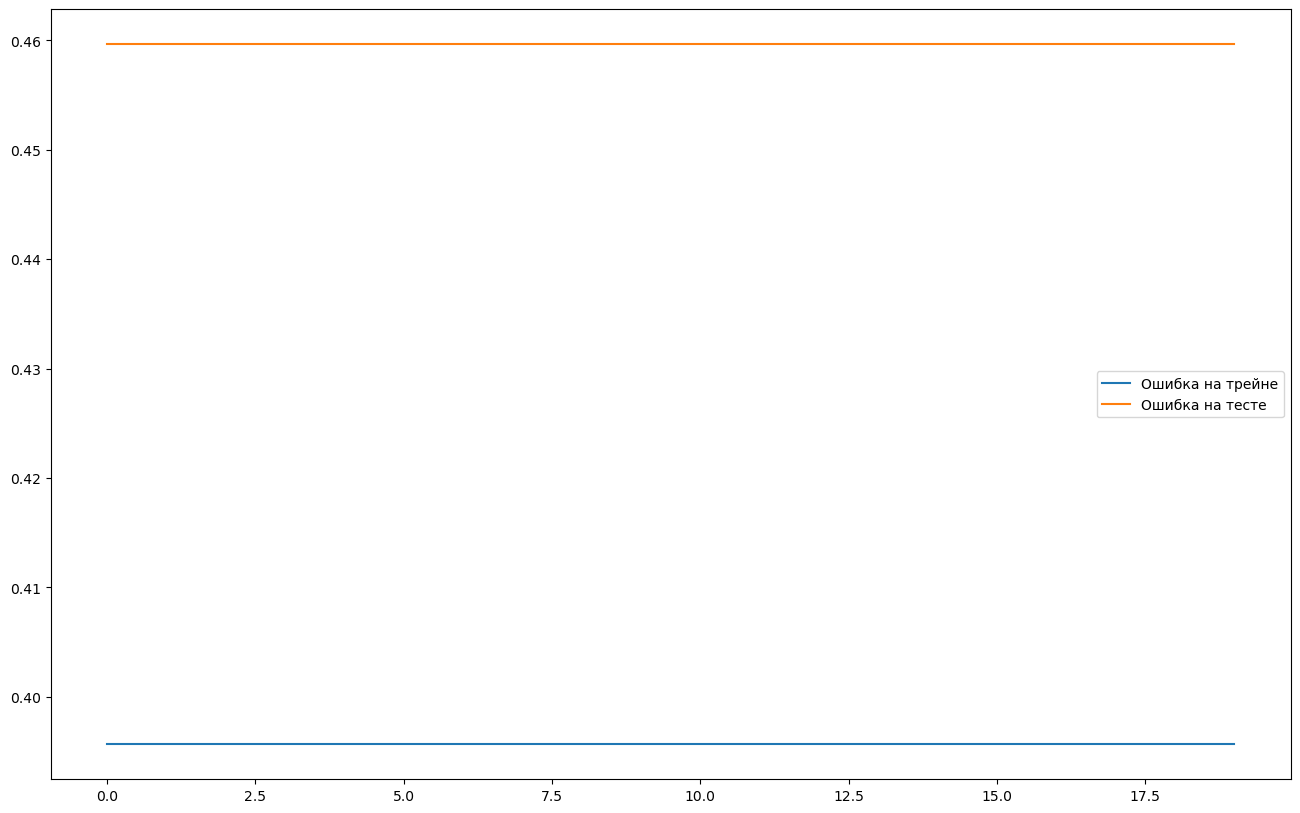

In [26]:
fig = plt.figure()
fig.set_size_inches(16,10)
plt.plot(train_errors)
plt.plot(test_errors)
plt.legend(['Ошибка на трейне', 'Ошибка на тесте'])
plt.show()

# Random forest

In [27]:
from sklearn.ensemble import RandomForestRegressor

RandomForest_pipe = ([('custom_transformer', col_transform),
                     ('random_forest', RandomForestRegressor(max_depth = 10, verbose = 1))])

RandomForest_pipe.fit(X_train, y_train)

AttributeError: 'list' object has no attribute 'fit'

In [ ]:
train_preds = RandomForest_pipe.predict(X_train)
test_preds = RandomForest_pipe.predict(X_test)

train_loss = np.mean((train_preds - y_train)**2)
test_loss = np.mean((test_preds - y_test)**2)

print(f'Качество на трейне: {train_loss:.5f}')
print(f'Качество на тесте: {test_loss:.5f}')

In [ ]:
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 400, num = 3)]
max_depth = [int(x) for x in np.linspace(start = 10, stop = 51, num = 4)]

param_grid = {
    'random_forest__n_estimators': n_estimators,
    'random_forest__max_depth': max_depth
}

search = GridSearchCV(RandomForest_pipe,
                     param_grid,
                     scoring = 'neg_mean_squared_error',
                     verbose = 10)
search.fit(X_train, y_train)
print(f'Best loss on CV: {search.best_score_:.5f}')
print(f'Best params: {search.best_params_}')
print(f'Best loss on test data: {search.score(X_test, y_test):.5f}')

# Выделение новых фичей

In [ ]:
df_train = pd.read_csv(
    'train.csv',
    converters={'unit_sales': lambda u: np.log1p(
        float(u)) if float(u) > 0 else 0},
    parse_dates=["date"],
    skiprows=range(1, 66458909)
)
df_train = da_train.loc[df_train.date>=pd.datetime(2017,1,1)]

df_2017 = df_train.set_index(
    ["store_nbr", "item_nbr", "date"])[["unit_sales"]].unstack(
        level=-1).fillna(0)
df_2017.columns = df_2017.columns.get_level_values(1)

In [28]:
### Вернемся к нашей задаче

X = df.drop("unit_sales", axis=1)
y = df["unit_sales"]

### Будем считать MSLE

y = y.apply(np.log1p)

### Добавим новые фичи 

New_X = pd.merge(X,
                 new_features.reset_index(),
                 on=['store_nbr', 'item_nbr'],
                 how='left'
                )

New_X.head()

NameError: name 'df' is not defined

In [ ]:
X_test, X_train = New_X[New_X.date>='2017-06-01'], New_X[(New_X.date>='2017-01-01') & (New_X.date<'2017-06-01')]
y_train, y_test = y[y.index.isin(X_train.index)], y[y.index.isin(X_test.index)]
X_test = X_test.drop('date', axis=1)
X_train = X_train.drop('date', axis=1)
New_X = New_X.drop('date', axis=1)

object_cols = ['store_nbr', 'item_nbr', 'onpromotion', 'month',
               'city', 'state', 'type', 'cluster', 'family',
               'class', 'perishable', 'holiday_type', 'locale',
               'locale_name', 'description', 'transferred']

X_test[object_cols] = X_test[object_cols].astype(object)
X_train[object_cols] = X_train[object_cols].astype(object)

In [ ]:
### Запишем заранее колонки для OHE
### и счетчиков
### а также вещественные колонки


cols_for_ohe = [x for x in object_cols if X_train[x].nunique() < 5]
cols_for_mte = [x for x in object_cols if X_train[x].nunique() >= 5]
numeric_cols = list(X_train.select_dtypes(exclude='object').columns)

### сохраним индексы этих колонок

cols_for_ohe_idx = [list(X_train.columns).index(col) for col in cols_for_ohe]
cols_for_mte_idx = [list(X_train.columns).index(col) for col in cols_for_mte]
numeric_cols_idx = [list(X_train.columns).index(col) for col in numeric_cols]

In [ ]:
t = [('OneHotEncoder', OneHotEncoder(), cols_for_ohe_idx),
     ('MeanTargetEncoder', TargetEncoder(), cols_for_mte_idx),
     ('StandardScaler', StandardScaler(), numeric_cols_idx)]

col_transform = ColumnTransformer(transformers=t)

In [ ]:
### Зафитим модель на новых данных
### И замерим качество на тесте и на трейне

RandomForest_best_pipe = Pipeline([("column_transformer",
                                    col_transform),
                  
                                   ("decision_tree", 
                                    RandomForestRegressor(max_depth=23,
                                                          n_estimators=500,
                                                          verbose=1))])

RandomForest_best_pipe.fit(X_train, y_train)

In [ ]:
train_preds = RandomForest_best_pipe.predict(X_train)
test_preds = RandomForest_best_pipe.predict(X_test)

train_loss = np.mean((train_preds - y_train)**2)
test_loss = np.mean((test_preds - y_test)**2)

print(f'Качество на трейне: {train_loss:.5f}')
print(f'Качество на тесте: {test_loss:.5f}')